In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/1017.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/4803.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/5106.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/3765.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/780.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/3952.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/227.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/2731.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/579.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/WithoutMask/353.png
/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation/Wi

# import libraries and function

In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import save_image
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
import os
import pathlib

# Data processing 

In [7]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Define transforms
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
dataset_path = pathlib.Path('../input/face-mask-12k-images-dataset/Face Mask Dataset')
Test_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Test'
Train_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
Val_path = '../input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'

In [9]:
# Load dataset
train_dataset = ImageFolder(root=Train_path, transform=transform)
val_dataset = ImageFolder(root=Val_path, transform=transform)
test_dataset = ImageFolder(root=Test_path, transform=transform)

In [10]:
# Define batch size
batch_size = 32

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [12]:
# explore more train loader for second last question ,we need latent space and labels
for batch_idx, (data, label) in enumerate(train_loader):
        data = data.to(device)
        print(f'data equal to {data}')
        label=label.to(device)
        print(f'labels are {label}')
        break
        

data equal to tensor([[[[ 0.3333,  0.3333,  0.3412,  ..., -0.3961, -0.4902, -0.5294],
          [ 0.3412,  0.3412,  0.3490,  ..., -0.3961, -0.4824, -0.5059],
          [ 0.3569,  0.3490,  0.3569,  ..., -0.4745, -0.4902, -0.4667],
          ...,
          [ 0.5922,  0.5294,  0.5216,  ..., -0.7961, -0.8275, -0.8588],
          [ 0.5765,  0.5294,  0.5216,  ..., -0.7961, -0.8039, -0.8431],
          [ 0.5529,  0.5294,  0.5216,  ..., -0.7412, -0.7647, -0.8118]],

         [[ 0.2549,  0.2706,  0.2627,  ..., -0.5529, -0.6157, -0.6392],
          [ 0.2627,  0.2784,  0.2706,  ..., -0.5373, -0.6000, -0.6078],
          [ 0.2706,  0.2706,  0.2784,  ..., -0.6000, -0.6000, -0.5529],
          ...,
          [ 0.3882,  0.4275,  0.4275,  ..., -0.8667, -0.8667, -0.8824],
          [ 0.3882,  0.4275,  0.4275,  ..., -0.8745, -0.8510, -0.8667],
          [ 0.4118,  0.4353,  0.4353,  ..., -0.8745, -0.8745, -0.8745]],

         [[-0.0039, -0.0118, -0.0118,  ..., -0.7020, -0.7804, -0.8039],
          [ 0.00

# Variational AutoEncoder model building

In [13]:
# Define VAE with UNet architecture
class VAE_UNet(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE_UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True), #inplace activation function ,not extra tensor matrix created 
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )
        #for latent representation
        self.fc_mu = nn.Linear(512*2*2, latent_dim)   #join leanearly for input as last layer of encoder  and output 
        self.fc_logvar = nn.Linear(512*2*2, latent_dim)  #join leanearly for input as last layer of encoder  and output 
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 256, kernel_size=4, stride=2, padding=1), #Increase the size of input as upsampling
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Softmax()  
        )

    def encode(self, x):   #fuction for ecoding part
        x = self.encoder(x)
        x = x.view(x.size(0), -1)  # reshape x with preserve x[0]= batch size and flatten other dimmension
        mu = self.fc_mu(x)    
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar): #function  for return  Z  value

        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):  # used in reconstruction
        z = z.view(z.size(0), -1, 1, 1) #reshape to add dimenssion
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)  #after ecoding we get latent representation mean and varience
        z = self.reparameterize(mu, logvar)  # for Z using mean and varience
        return self.decode(z), mu, logvar

In [14]:
# Define KL  annealing 
def kl_annealing(epoch, epochs, warmup_epochs): #used as regularization  curr_epoch=epoch, total epochs=epochs, warmup_epochs -a value less than epochs
    if epoch < warmup_epochs:
        return 0.0
    else:
        return min(1.0, (epoch - warmup_epochs) / (epochs - warmup_epochs)) #return divergence


In [15]:
# Reconstruction loss 

def loss_function(recon_x, x, mu, logvar, kl_weight):
    # Resize the reconstructed batch to match the input batch size
    recon_x_resized = nn.functional.interpolate(recon_x, size=x.size()[2:], mode='bilinear', align_corners=False)
    
    BCE = nn.MSELoss(reduction='sum')(recon_x_resized, x)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) 
    return BCE + kl_weight * KLD


# VAE Training

In [16]:
# Create VAE model instance
latent_dim = 100
vae_model = VAE_UNet(latent_dim).to(device) #initialize the VAE_Unet model

# Define optimizer
optimizer = optim.Adam(vae_model.parameters(), lr=0.001)

In [18]:
# Training loop
num_epochs = 10
validation_loss=[]
train_loss=[]
latent_space=[]  #'''storing ''' mean of latent representation
latent_space_label=[]
for epoch in range(num_epochs):
    vae_model.train()
    epoch_train_loss = 0
    for batch_idx, (data, label) in enumerate(train_loader):
        label=label.to(device)
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae_model(data)  # model return reconstruction ,mean ,varience
        kl_weight = kl_annealing(epoch, num_epochs, warmup_epochs=5)  #calculate kl
        loss = loss_function(recon_batch, data, mu, logvar, kl_weight) # reconstruction loss
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
        latent_space.append(mu)
        latent_space_label.append(label)
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    # Validation
    vae_model.eval()
    with torch.no_grad():
        val_loss = 0
        for val_data, _ in val_loader:
            val_data = val_data.to(device)
            val_recon_batch, val_mu, val_logvar = vae_model(val_data)
            val_loss += loss_function(val_recon_batch, val_data, val_mu, val_logvar, kl_weight).item()

        val_loss /= len(val_loader)
        validation_loss.append(val_loss)
        train_loss.append(epoch_train_loss / len(train_loader))
        print(f'Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}')


Epoch [1/10], Batch [1/313], Loss: 104330.7344
Epoch [1/10], Batch [101/313], Loss: 50647.4219
Epoch [1/10], Batch [201/313], Loss: 48461.2930
Epoch [1/10], Batch [301/313], Loss: 35261.5312
Epoch [1/10], Validation Loss: 38787.2365
Epoch [2/10], Batch [1/313], Loss: 35821.0938
Epoch [2/10], Batch [101/313], Loss: 39260.2188
Epoch [2/10], Batch [201/313], Loss: 27009.2793
Epoch [2/10], Batch [301/313], Loss: 27687.8516
Epoch [2/10], Validation Loss: 29759.1467
Epoch [3/10], Batch [1/313], Loss: 27494.1777
Epoch [3/10], Batch [101/313], Loss: 33548.8828
Epoch [3/10], Batch [201/313], Loss: 29570.5586
Epoch [3/10], Batch [301/313], Loss: 24439.9277
Epoch [3/10], Validation Loss: 26228.5230
Epoch [4/10], Batch [1/313], Loss: 25815.1758
Epoch [4/10], Batch [101/313], Loss: 25570.7461
Epoch [4/10], Batch [201/313], Loss: 24457.2051
Epoch [4/10], Batch [301/313], Loss: 23684.7930
Epoch [4/10], Validation Loss: 23676.5402
Epoch [5/10], Batch [1/313], Loss: 23644.8438
Epoch [5/10], Batch [101/

In [19]:
# Save trained model parameters
torch.save(vae_model.state_dict(), 'vae_model.pth')

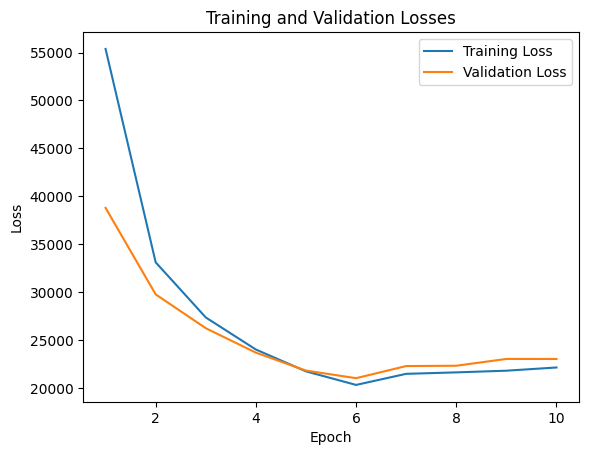

In [20]:
# Plotting the training and validation losses
plt.plot(range(1, num_epochs + 1), train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Comparison of the reconstruction ability of the VAE on input images of test set

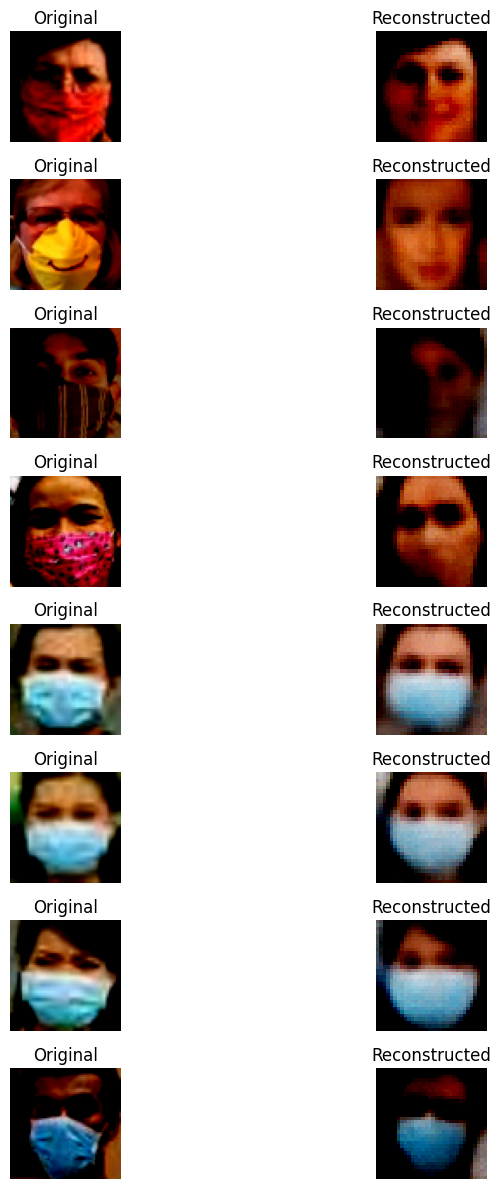

In [21]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Set the model to evaluation mode
vae_model.eval()

# Generate reconstructed images for a batch of test data
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        recon_batch, _, _ = vae_model(data)
        # Comparing original images with reconstructed images visually
        num_images = min(data.size(0), 8)  # Choose the number of images to display
        fig, axes = plt.subplots(num_images, 2, figsize=(10, 12))
        for i in range(num_images):
            original_img = data[i].cpu().permute(1, 2, 0)
            reconstructed_img = recon_batch[i].cpu().permute(1, 2, 0)
            axes[i, 0].imshow(original_img)
            axes[i, 0].set_title('Original')
            axes[i, 0].axis('off')
            axes[i, 1].imshow(reconstructed_img)
            axes[i, 1].set_title('Reconstructed')
            axes[i, 1].axis('off')
        plt.tight_layout()
        plt.show()
        break  # Only display one batch of images


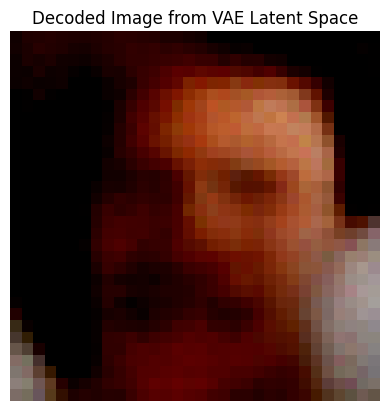

In [24]:
#generate image from 
# Set the model to evaluation mode
vae_model.eval()

# Sample a point from the latent space
latent_point = torch.randn(1, latent_dim).to(device)

# Decode the latent point
with torch.no_grad():
    decoded_vae = vae_model.decode(latent_point)

# Plot the decoded image
decoded_vae_img = decoded_vae.squeeze().permute(1, 2, 0).cpu().numpy()
plt.imshow(decoded_vae_img)
plt.title('Decoded Image from VAE Latent Space')
plt.axis('off')
plt.show()


# Randomly sample a point from the latent space of the VAE and compare the output from the decoder with that of a normal autoencoder 

In [23]:
# Define the architecture of the autoencoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the autoencoder
ae_model = Autoencoder().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(ae_model.parameters(), lr=0.001)

# Train the autoencoder
num_epochs = 10
for epoch in range(num_epochs):
    ae_model.train()
    running_loss = 0.0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed = ae_model(data)
        loss = criterion(reconstructed, data)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")



Epoch [1/10], Loss: 0.2050
Epoch [2/10], Loss: 0.1723
Epoch [3/10], Loss: 0.1703
Epoch [4/10], Loss: 0.1686
Epoch [5/10], Loss: 0.1677
Epoch [6/10], Loss: 0.1672
Epoch [7/10], Loss: 0.1668
Epoch [8/10], Loss: 0.1666
Epoch [9/10], Loss: 0.1663
Epoch [10/10], Loss: 0.1662


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

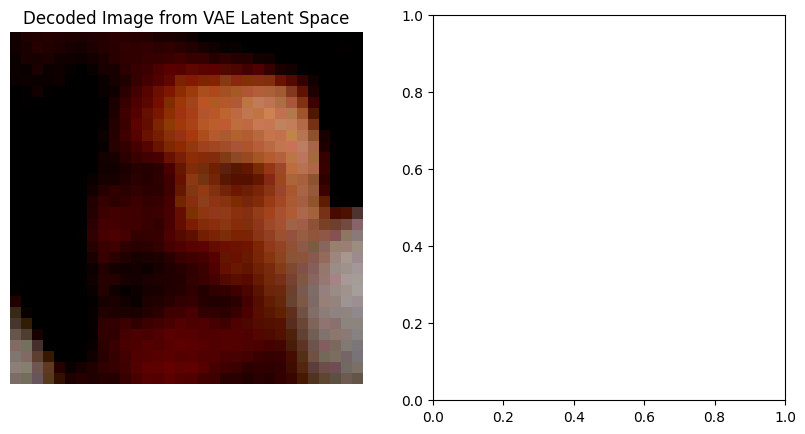

In [95]:
# Evaluate the autoencoder
ae_model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        reconstructed_ae = ae_model(data)
        break  # Only evaluate one batch

# Compare decoded_vae and decoded_ae visually
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
decoded_vae_img = decoded_vae.squeeze().permute(1, 2, 0).cpu().numpy()
axes[0].imshow(decoded_vae_img)
axes[0].set_title('Decoded Image from VAE Latent Space')
axes[0].axis('off')

decoded_ae_img = reconstructed_ae.squeeze().permute(1, 2, 0).cpu().numpy()
axes[1].imshow(decoded_ae_img)
axes[1].set_title('Decoded Image from Autoencoder')
axes[1].axis('off')

plt.show()

# Plotting the t-SNE plot of VAE and comparison with normal autoencoder

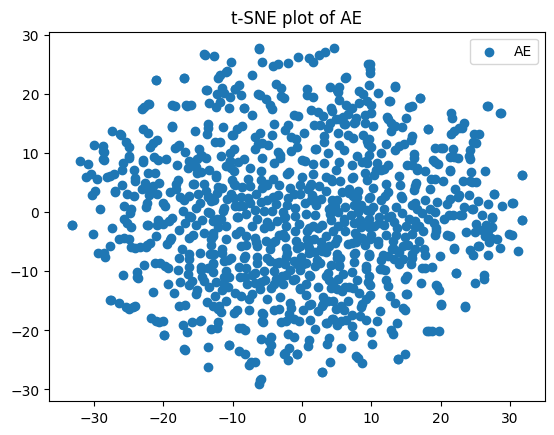

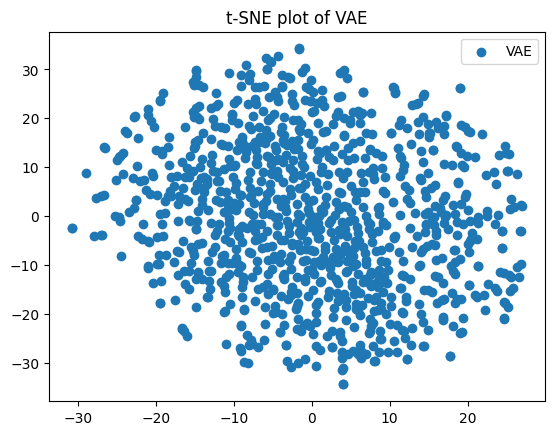

ValueError: too many values to unpack (expected 3)

In [101]:
#Plotting the t-SNE plot 
from sklearn.manifold import TSNE
# Assuming latent_data_vae is a tensor containing latent representations of VAE
# Plot t-SNE
plt.scatter(tsne_vae[:, 0], tsne_vae[:, 1], label='AE')
plt.title('t-SNE plot of AE')
plt.legend()
plt.show()

# Assuming latent_data_vae is a tensor containing latent representations of VAE
latent_data_vae = []

# Collect latent representations for test dataset
vae_model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        _, mu, _ = vae_model(data)
        latent_data_vae.append(mu)
latent_data_vae = torch.cat(latent_data_vae, dim=0).cpu().numpy()

# Perform t-SNE
tsne_vae = TSNE(n_components=2).fit_transform(latent_data_vae)

# Plot t-SNE
plt.scatter(tsne_vae[:, 0], tsne_vae[:, 1], label='VAE')
plt.title('t-SNE plot of VAE')
plt.legend()
plt.show()

latent_data_ae = []

# Collect latent representations for test dataset
ae_model.eval()
with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        _, mu, _ = ae_model(data)
        latent_data_ae.append(mu)
latent_data_ae = torch.cat(latent_data_ae, dim=0).cpu().numpy()

# Perform t-SNE
tsne_ae = TSNE(n_components=2).fit_transform(latent_data_ae)



In [106]:
ae_model.eval()
latent_space = []
with torch.no_grad():
    for batch in test_loader:
        x, _ = batch
        x = x.to(device)
        latent_representation = ae_model.encoder(x).cpu().numpy()
        latent_space.append(latent_representation)
    latent_space=np.concatenate(latent_space)    
    

In [ ]:
# Reduce the number of samples for t-SNE computation
num_samples = 100 # Adjust this number as needed
latent_space_subset = latent_space[:num_samples]

# Apply t-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42)
latent_tsne = tsne.fit_transform(latent_space_subset)

# Plot t-SNE embeddings
plt.figure(figsize=(10, 8))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], marker='.', c='b', alpha=0.5)
plt.title('t-SNE Plot of Latent Space (Autoencoder)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Smoothness of Latent Space

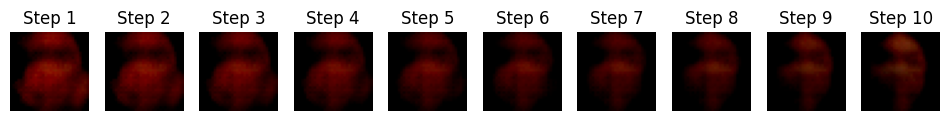

In [21]:


# Define the number of interpolation steps
num_steps = 10

# Sample two random points from the latent space
latent_point_1 = torch.randn(1, latent_dim).to(device)
latent_point_2 = torch.randn(1, latent_dim).to(device)

# Interpolate between the two latent points
interpolated_latent_points = torch.stack([latent_point_1 + (i / (num_steps - 1)) * (latent_point_2 - latent_point_1) for i in range(num_steps)])

# Decode the interpolated latent points
vae_model.eval()
with torch.no_grad():
    decoded_interpolations = vae_model.decode(interpolated_latent_points)

# Plot the decoded images
plt.figure(figsize=(12, 6))
for i in range(num_steps):
    plt.subplot(1, num_steps, i+1)
    decoded_img = decoded_interpolations[i].cpu().permute(1, 2, 0).numpy()
    plt.imshow(decoded_img)
    plt.title(f'Step {i+1}')
    plt.axis('off')
plt.show()


# The latent representation of VAE and evaluate its performance on classification task(with or without mask) and also compare this with a regular autoencoder

In [79]:
len(latent_space),
len(latent_space[0])


32

In [87]:
latent=[]
for tensor_data in latent_space:
    # Calculate the mean of each column
    for t in tensor_data:
        means = torch.mean(t)
        

        latent.append(means.detach().numpy())
    

In [88]:
len(latent)
latent[3]

array(0.0003205, dtype=float32)

In [66]:
len(latent_space_label)
latent_space_label[0]

tensor([0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        0, 1, 1, 1, 0, 1, 1, 1])

In [67]:
labelss=[]
for tensor_data in latent_space_label:
    
    tensor_data=tensor_data.numpy()
    labelss=np.concatenate((labelss, tensor_data))
    
    

In [69]:
len(labelss)

100000

In [89]:

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Now you can proceed with train_test_split and other operations
X_train, X_test, y_train, y_test = train_test_split(latent, labelss, test_size=0.2, random_state=42)

In [97]:
# Evaluate the classifier
classifier=LogisticRegression() #initialise the model
X_train_array = np.array(X_train)
X_test_array = np.array(X_test)
X_train_reshaped = X_train_array.reshape(-1, 1) # add a mimmension
X_test_reshaped =X_test_array.reshape(-1, 1)
classifier.fit(X_train_reshaped, y_train)  # train the model
accuracy = classifier.score(X_test_reshaped, y_test) #test the model
print("Classifier Accuracy VAE:", accuracy)

Classifier Accuracy VAE: 0.6267


In [99]:
len(latent_data_vae)

992

#  Way in which VAE's ability can be improved

1. better latent space representaion

2. decrease mse loss


3. data augmentation (increase datasize)

3.  regularization annealing

4. hyper parameter tunning

5. better training epoch



In [ ]:
images=os.listdir(Train_path)
images

In [ ]:
import matplotlib.image as mpimg

In [ ]:
Mask_img =  mpimg.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithMask/273.png')
plt.imshow(Mask_img)
plt.title("person with mask")

In [ ]:
Mask_img =  mpimg.imread('../input/face-mask-12k-images-dataset/Face Mask Dataset/Train/WithoutMask/14.png')
plt.imshow(Mask_img)
plt.title("person without mask")